# Tutorial: evaluating the different normalisation schemes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import sys
import os
import numpy as np
import xarray as xr


##### Import local functions
sys.path.append(os.path.abspath(os.path.join('..')))
import funs

In [2]:
########## Parameters

version_list = ['', '_q2q_v1', '_q2q_v2', '_q2q_v3']
version_list_nice_names = ['no_q2q', 'q2q_v1', 'q2q_v2', 'q2q_v3']
version_list_nice_names_complete = ['historical'] + version_list_nice_names

clustering_list = ['NUTS2', 'NUTS3']

carrier_list = ['onwind', 'solar']

domain_list = ['iberia', 'europe']

year_list = list(range(2016, 2024))


year_dic = {'iberia': list(range(2016, 2024)),
            'europe': [2019, 2020, 2023]
            }




## *RMSE*

In [3]:
RMSE = xr.DataArray(
    np.empty((len(version_list_nice_names), 
              len(clustering_list), 
              len(carrier_list), 
              len(domain_list), 
              len(year_list))
            ),
    coords={
            'version': version_list_nice_names,
            'clustering': clustering_list,
            'carrier': carrier_list,
            'domain': domain_list,
            'year': year_list,
            },
    dims=['version', 'clustering', 'carrier', 'domain', 'year']
)

In [4]:
CF = xr.DataArray(
    np.empty((len(version_list_nice_names_complete), 
              len(clustering_list), 
              len(carrier_list), 
              len(domain_list), 
              len(year_list))
            ),
    coords={
            'version': version_list_nice_names_complete,
            'clustering': clustering_list,
            'carrier': carrier_list,
            'domain': domain_list,
            'year': year_list,
            },
    dims=['version', 'clustering', 'carrier', 'domain', 'year']
)

In [5]:
##### Load installed capacities
cap_path = '../data/'
cap_file = 'installed_capacity.csv'

df_capacity = pd.read_csv(cap_path+cap_file, index_col=0)

In [8]:
for carrier in carrier_list:

    for year in year_list:

        ### Load historical data
        hist_path = '../data/historical_data/'
        hist_file = f'{carrier}_{year}.csv'    
        df_historical = pd.read_csv(hist_path+hist_file, index_col=0, parse_dates=True)
        ### Historical data were obtained 'tz-aware' to impose UTC+00. Make it 'tz-naive'
        df_historical.index = df_historical.index.tz_localize(None)
        ### Rename value to value_historical
        df_historical.rename(columns={'value': 'value_historical'}, inplace=True)



        for domain in domain_list:
            
            for clustering in clustering_list:

                ### If modelled data exists
                mod_path = '../data/modelled_data/'
                mod_file = f'{carrier}_{domain}_{year}_{clustering}.csv'

                if os.path.exists(mod_path+mod_file):

                    ### Load modelled data, and rename no_q2q column
                    df_modelled = pd.read_csv(mod_path+mod_file, index_col=0, parse_dates=True)
                    df_modelled.rename(columns={'value': 'value_no_q2q'}, inplace=True)
                    
                    ### Join historial and modelled data in case there is some date mismatch
                    df = df_historical.join(df_modelled, how='inner')  # une según índice (fechas)
                    

                    for version in version_list_nice_names_complete:

                        y_true = df['value_historical']
                        y_pred = df[f'value_{version}']

                        y_true_adim = y_true/df_capacity.at[year,carrier]
                        y_pred_adim = y_pred/df_capacity.at[year,carrier]

                        if version == 'historical':

                            CF.loc[version,clustering,carrier,domain,year] = np.mean(y_true_adim)

                        else:

                            CF.loc[version,clustering,carrier,domain,year] = np.mean(y_pred_adim)
                            RMSE.loc[version,clustering,carrier,domain,year] = funs.fun_rmse(y_true_adim, y_pred_adim)
                        
                    
                    

                              
                


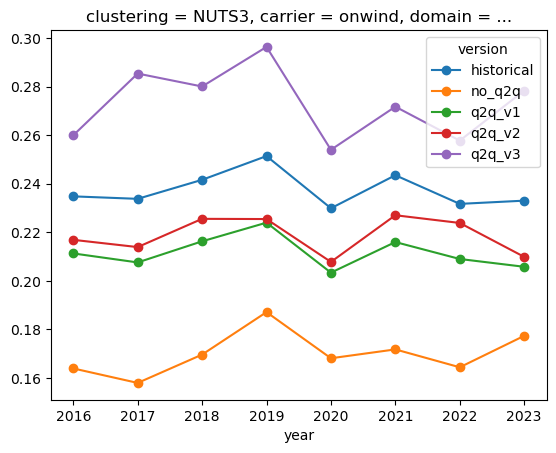

In [26]:
CF_subset = CF.sel(clustering='NUTS3',
                   carrier='onwind',
                   domain='iberia',
                   )


CF_subset.plot.line(x='year', hue='version', marker='o')


In [10]:
CF_subset

<xarray.DataArray (version: 5, year: 8)> Size: 320B
array([[0.23479363, 0.23377246, 0.24161155, 0.25138688, 0.2298893 ,
        0.24350075, 0.23169573, 0.23302503],
       [0.15500247, 0.14870136, 0.16176272, 0.17794572, 0.15978634,
        0.16257778, 0.1562405 , 0.16731095],
       [0.2182303 , 0.21538563, 0.22102568, 0.23171047, 0.21051462,
        0.22403194, 0.21402199, 0.21377689],
       [0.22647528, 0.22474175, 0.23330986, 0.2352207 , 0.21753527,
        0.23804613, 0.23377229, 0.22115735],
       [0.27008966, 0.29688993, 0.28942553, 0.30895665, 0.26650476,
        0.27802747, 0.26202382, 0.29009634]])
Coordinates:
  * version     (version) <U10 200B 'historical' 'no_q2q' ... 'q2q_v2' 'q2q_v3'
    clustering  <U5 20B 'NUTS2'
    carrier     <U6 24B 'onwind'
    domain      <U6 24B 'iberia'
  * year        (year) int64 64B 2016 2017 2018 2019 2020 2021 2022 2023

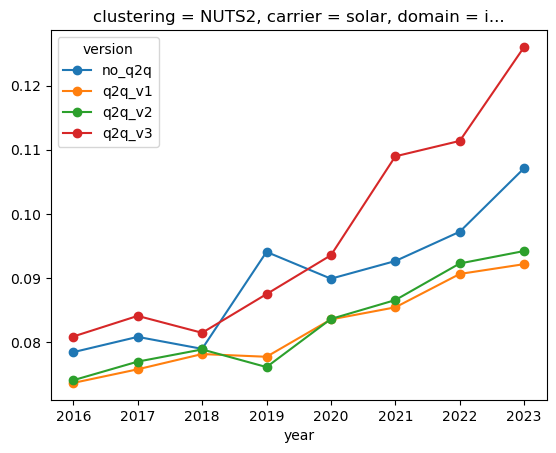

In [ ]:
RMSE_subset = RMSE.sel(clustering='NUTS2',
                       carrier='solar',
                       domain='iberia')


RMSE_subset.plot.line(x='year', hue='version', marker='o')

(array([83., 41.,  9., 29., 28., 20.,  9., 17., 12.,  7.]),
 array([   0.        ,  297.43260482,  594.86520964,  892.29781447,
        1189.73041929, 1487.16302411, 1784.59562893, 2082.02823375,
        2379.46083857, 2676.8934434 , 2974.32604822]),
 <BarContainer object of 10 artists>)

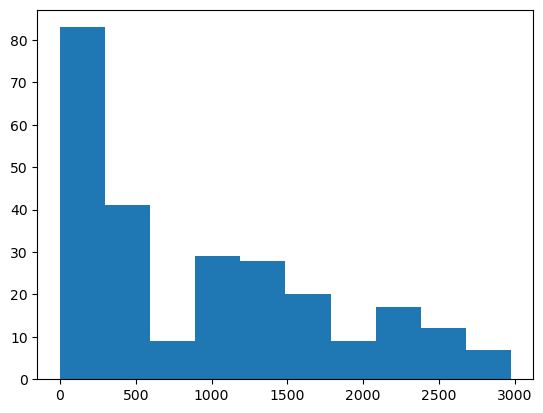

In [ ]:
RMSE.plot()

In [ ]:
rmse_local

2429.98024692469

In [ ]:
df

,value,value_no_q2q,value_q2q_v1,value_q2q_v2,value_q2q_v3
2023-01-01 00:00:00,19.58,0.0,466.25,554.91,684.86
2023-01-01 01:00:00,19.67,0.0,466.25,554.91,684.86
2023-01-01 02:00:00,19.33,0.0,466.25,554.91,684.86
2023-01-01 03:00:00,19.83,0.0,466.25,554.91,684.86
2023-01-01 04:00:00,18.83,0.0,466.25,554.91,684.86
...,...,...,...,...,...
2023-12-31 19:00:00,29.08,0.0,466.25,554.91,684.86
2023-12-31 20:00:00,29.00,0.0,466.25,554.91,684.86
2023-12-31 21:00:00,29.00,0.0,466.25,554.91,684.86
2023-12-31 22:00:00,29.00,0.0,466.25,554.91,684.86
